In [14]:
#from https://medium.com/@nutanbhogendrasharma/pytorch-convolutional-neural-network-with-mnist-dataset-4e8a4265e118
import torch
import torch.nn.functional as F
import torch.distributions as distributions
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision import transforms
import matplotlib.pyplot as plt
from torch.autograd import Variable
import numpy as np

In [15]:
train_data = datasets.MNIST(
    root = 'data',
    train = True,                         
    transform = ToTensor(), 
    download = True,            
)
test_data = datasets.MNIST(
    root = 'data', 
    train = False, 
    transform = ToTensor()
)

In [16]:
for i in range(len(train_data.data)):
    if (i % 2 == 0):
        train_data.data[i] = torch.randn(*train_data.data[i].shape)
        train_data.targets[i] = np.random.uniform(1,10)

In [17]:
from torch.utils.data import DataLoader
loaders = {
    'train' : torch.utils.data.DataLoader(train_data, 
                                          batch_size=100, 
                                          shuffle=True, 
                                          num_workers=1),
    
    'test'  : torch.utils.data.DataLoader(test_data, 
                                          batch_size=100, 
                                          shuffle=True, 
                                          num_workers=1),
}
loaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x7fa28e20b730>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x7fa28e20b0d0>}

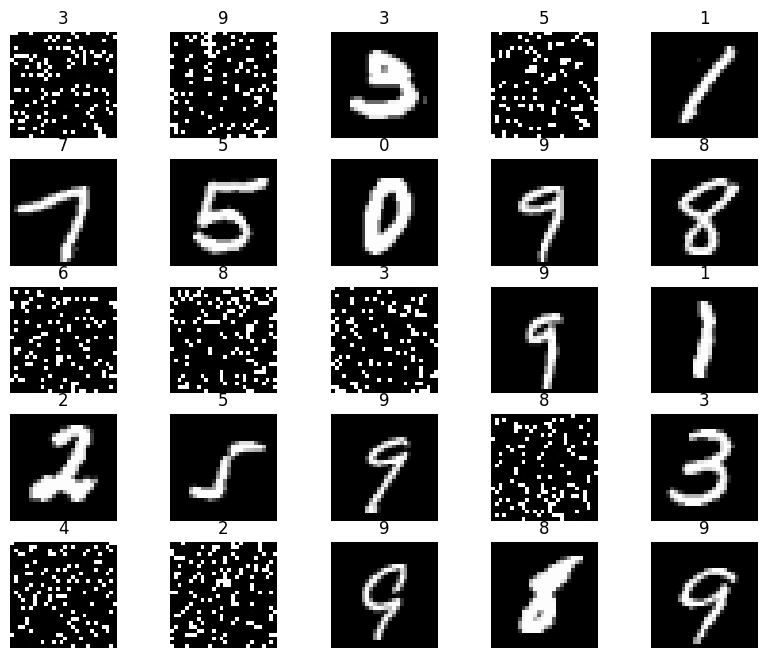

In [18]:
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [19]:
import torch.nn as nn
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=5,              
                stride=1,                   
                padding=2,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(16, 32, 5, 1, 2),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        # fully connected layer, output 10 classes
        self.out = nn.Linear(32 * 7 * 7, 10)
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)       
        output = self.out(x)
        return output, x    # return x for visualization
        

In [20]:
cnn = CNN()
print(cnn)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)


In [21]:
loss_func = nn.CrossEntropyLoss()   
loss_func

CrossEntropyLoss()

In [22]:
from torch import optim
optimizer = optim.Adam(cnn.parameters(), lr = 0.01)   
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.01
    weight_decay: 0
)

In [23]:
class Policy(torch.nn.Module):
    def __init__(self):#, state_size, action_size, hidden_dims):#, dropout = 0.5):
        super(Policy, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=5,              
                stride=1,                   
                padding=2,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(16, 32, 5, 1, 2),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        # fully connected layer, output 2 classes
        self.out = nn.Linear(32 * 7 * 7, 2)


    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)       
        output = self.out(x)
        return output
    
    def get_action(self, observations):
        state = torch.FloatTensor(observations).unsqueeze(0)
        action_pred = self.forward(state)
        action_prob = F.softmax(action_pred)
        dist = distributions.Categorical(action_prob)
        action = dist.sample()
        return action.item(), dist.log_prob(action)
        

In [24]:
policy_net = Policy()
print(policy_net)
policy_optimizer = torch.optim.Adam(policy_net.parameters(), lr=0.0001)

Policy(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=2, bias=True)
)


In [ ]:
#from https://notebook.community/Diyago/Machine-Learning-scripts/DEEP%20LEARNING/Pytorch%20from%20scratch/TODO/Autoencoders/denoising-autoencoder/Denoising_Autoencoder_Solution
num_epochs = 50
noise_factor = 1
def train(num_epochs, cnn, pg, loaders):
    gamma = 1
    cnn.train()
        
    # Train the model
    total_step = len(loaders['train'])
    
    for epoch in range(num_epochs):
        rewards = []
        log_probs = []
        
        for i, (images, labels) in enumerate(loaders['train']):
            correct = 0
            correct_2 = 0
            
                
            labels_copy = torch.clone(labels)
            # gives batch data, normalize x when iterate train_loader
            b_x = Variable(images)   # batch x
            b_y = Variable(labels)   # batch y
            output = cnn(b_x)[0]
            loss = loss_func(output, b_y)
            
            pred_labels = torch.max(output, 1).indices
            correct += (pred_labels == labels).sum().item()

            accuracy = correct / len(b_y)
            
            #get agent to look at all images and select
            keep_imgs = []
            for j in range(len(b_x)):
                keep, log_prob = pg.get_action(b_x[j])
                keep_imgs.append(keep)
                log_probs.append(log_prob)
                if (j != (len(b_x) -1)):
                    rewards.append(0)
            
            new_batch = []
            new_labels = []
            for j in range(len(keep_imgs)):
                if keep_imgs[j] == 1:
                    new_batch.append(torch.FloatTensor(images[j]))
                    new_labels.append(labels_copy[j].item())
                    
            #print(new_batch)
            

            if (len(new_batch) == 0):
                accuracy_2 = 0
            else:
                t = torch.stack(new_batch)
                l = new_labels.copy()

                b_x_2 = Variable(t)
                b_y_2 = Variable(torch.Tensor(l))

                #get output again based on those images
                output_2 = cnn(b_x_2)[0]

                #compare the accuracy between those outputs
                pred_labels_2 = torch.max(output_2, 1).indices
                correct_2 += (pred_labels_2 == torch.Tensor(new_labels)).sum().item()
                               
                accuracy_2 = correct_2 / len(b_y_2)
            
            rewards.append(100*(accuracy_2 - accuracy))
                        
            # clear gradients for this training step   
            optimizer.zero_grad()           
            
            # backpropagation, compute gradients 
            loss.backward()    
            # apply gradients             
            optimizer.step()   
            
            
            if (i+1) % 100 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.4f}, Accuracy with Agent: {:.4f}' 
                       .format(epoch + 1, num_epochs, i + 1, total_step, loss.item(), accuracy, accuracy_2))
        
        #pg loss function
        G = [gamma ** j for j in range(len(rewards) + 1)]
        discount_rewards = ([a * b for a,b in zip(G, rewards)])
        
        policy_loss = 0
        for j in range(len(log_probs)):
            policy_loss += -log_probs[j]*(discount_rewards[j])
        

        #training step for PG network
        policy_optimizer.zero_grad()
        policy_loss.backward()
        policy_optimizer.step()

            

train(num_epochs, cnn, policy_net, loaders)

/var/folders/x4/_sfmqqbj0sq0f3v44_gt4f7h0000gn/T/ipykernel_1519/861499610.py:35: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  action_prob = F.softmax(action_pred)


Epoch [1/50], Step [100/600], Loss: 1.2395, Accuracy: 0.5400, Accuracy with Agent: 0.5909


In [ ]:
def test():
    # Test the model
    cnn.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        acc = 0
        count = 0
        for images, labels in loaders['test']:
            test_output, last_layer = cnn(images)
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            accuracy = (pred_y == labels).sum().item() / float(labels.size(0))
            acc += accuracy
            count += 1

    print('Test Accuracy of the model on the 10000 test images: %.2f' % (acc/count))

test()

In [ ]:
for i in range(len(test_data.data)):
    if (i % 2 == 0):
        test_data.data[i] = torch.randn(*test_data.data[i].shape)
        test_data.targets[i] = np.random.uniform(1,10)

In [ ]:
noisy_loader = {
    'test'  : torch.utils.data.DataLoader(test_data, 
                                          batch_size=100, 
                                          shuffle=True, 
                                          num_workers=1),
}
noisy_loader

In [ ]:
def test_noisy():
    # Test the model
    cnn.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        acc = 0
        count = 0
        for images, labels in noisy_loader['test']:
            test_output, last_layer = cnn(images)
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            accuracy = (pred_y == labels).sum().item() / float(labels.size(0))
            acc += accuracy
            count += 1

    print('Test Accuracy of the model on the 10000 test images: %.2f' % (acc/count))

test_noisy()

In [ ]:
def test_noisy_with_agent(pg):
    # Test the model
    cnn.eval()
    with torch.no_grad():
        total = 0
        acc = 0
        count = 0
        for images, labels in noisy_loader['test']:
            count += 1
            correct_2 = 0
            labels_copy = torch.clone(labels)
            b_x = Variable(images)   # batch x
            b_y = Variable(labels)   # batch y

            keep_imgs = []
            for j in range(len(b_x)):
                keep, log_prob = pg.get_action(b_x[j])
                keep_imgs.append(keep)
            
            new_batch = []
            new_labels = []
            for j in range(len(keep_imgs)):
                if keep_imgs[j] == 1:
                    new_batch.append(torch.FloatTensor(images[j]))
                    new_labels.append(labels_copy[j].item())
                    
            
            if (len(new_batch) == 0):
                accuracy_2 = 0
            else:
                t = torch.stack(new_batch)
                l = new_labels.copy()

                b_x_2 = Variable(t)
                b_y_2 = Variable(torch.Tensor(l))

                #get output again based on those images
                output_2 = cnn(b_x_2)[0]

                #compare the accuracy between those outputs
                pred_labels_2 = torch.max(output_2, 1).indices
                correct_2 += (pred_labels_2 == torch.Tensor(new_labels)).sum().item()
                               
                accuracy_2 = correct_2 / len(b_y_2)
                                             
            acc += accuracy_2
            
        print('Test Accuracy of the model on the 10000 test images: %.2f' % (acc/count))
        return new_batch, new_labels
        
new_images, new_labels = test_noisy_with_agent(policy_net)

In [ ]:
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(new_images), size=(1,)).item()
    img = new_images[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(new_labels[sample_idx])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [ ]:
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(test_data), size=(1,)).item()
    img, label = test_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()